In [3]:
from __future__ import division
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tqdm
# import seaborn as sns
# sns.set_style("whitegrid", {'axes.grid' : False})
import pyximport
pyximport.install()

import sys, os
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import pulse_utils as pu
import trace_param as trcp
import pulse_fit_powell as pfp
import pickle
import heralded_pulses_analysis as hpa
from scipy.signal import convolve

In [4]:
results_directory='./'

In [5]:
data = pandas.read_csv(results_directory+\
                'results.csv'
                      )
try:
    df = data[data['Unnamed: 0']!=np.nan]
except:
    df = data
df = df.drop_duplicates()
# print df.dtypes
# print df[0:1]
# df.fname = df.fname.astype(str)
# df.set_index('fname')
# print len(df)
# print df[0:2]

## Merging of fit and area data (optional)

In [6]:
trace_parameters = np.genfromtxt('trace_params.dat',
                    dtype=[('fname', 'U256'),
                           ('numedges', 'int8'),
                        ('area_win', 'float64'),
                        ('area_win_abs', 'float64'),
                       ('height', 'float64'),
                       ('rms', 'float64')
                       ])

In [7]:
df_params = pandas.DataFrame(trace_parameters)
df_params.fname = df_params.fname.astype(str)
df_params.set_index('fname');
# print df_params.dtypes
# print df_params['fname'][0:1]

In [8]:
df = df.merge(df_params)
# print df['fname'][0]
# print df_params['fname'][1]

In [9]:
df.to_csv('results_with_params',header=False)

In [10]:
print df.dtypes
print len(df)

Unnamed: 0                int64
fname                    object
one_x_offset_init       float64
one_amplitude_init      float64
two_amplitude_init      float64
two_x_offset_init       float64
one_x_offset_fitted     float64
one_amplitude_fitted    float64
two_amplitude_fitted    float64
two_x_offset_fitted     float64
redchi                  float64
numedges                   int8
area_win                float64
area_win_abs            float64
height                  float64
rms                     float64
dtype: object
7160


In [11]:
def hist(data,numbins,lims, label='', plot=True, alpha=.5):
    """Creates and Plots numpy histogram, removing the last bin""" 
    y, binEdges = np.histogram(data,numbins,range=(lims))
    if plot:
        y_err = np.sqrt(y)
        step = binEdges[1]-binEdges[0]
        _bins = binEdges[:-1]+step/2
        plt.errorbar(_bins,y,yerr=y_err,fmt='.',color='blue', alpha=alpha)
        plt.xlim(lims)
    return y, _bins

In [33]:
bin_duration = 5 # ns
g2_duration = 10000
numbins = int(g2_duration/bin_duration)
lims = [0,g2_duration] #units ns

In [34]:
# df['tau'] = np.abs(df['two_x_offset_init']-df['one_x_offset_init'])*1e9
df['tau'] = np.abs(df['two_x_offset_fitted']-df['one_x_offset_fitted'])*1e9

In [35]:
tau = df['tau']

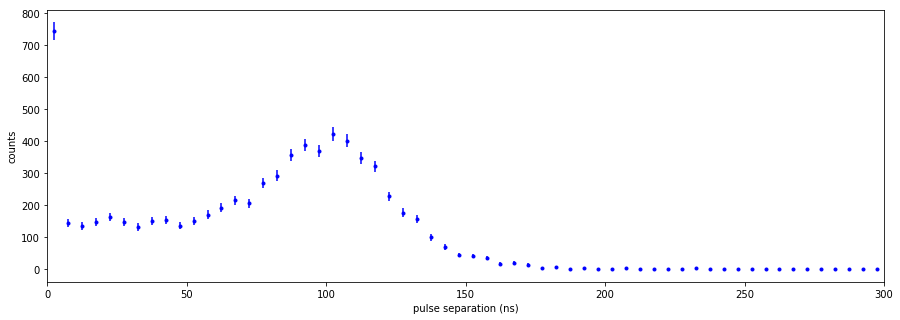

In [36]:
%matplotlib inline
plt.figure(figsize=(15,5))
y, bins = hist(tau,numbins=numbins,lims=lims, plot=True, alpha=1) # raw
plt.xlim(0,300)
plt.xlabel('pulse separation (ns)')
plt.ylabel('counts')
plt.show()

In [37]:
np.savetxt('tau_90ns.dat',tau)

In [38]:
np.savetxt('g2_90ns.dat',zip(bins,y),header='tau(ns)\tcounts',fmt=('%i','%i'))

In [1]:
# Fit 2 gaussians

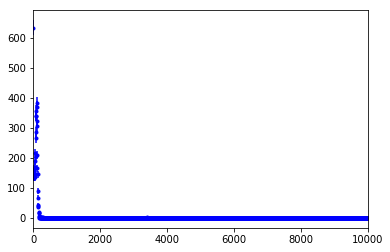

In [26]:
sgntau = (df['two_x_offset_fitted']-df['one_x_offset_fitted'])*1e9
y, bins = hist(sgntau,numbins=2000,lims=lims, plot=True, alpha=1) # raw

In [27]:
# assume and fit to 3 Gaussian model
from lmfit import Parameters
from lmfit.models import GaussianModel

peaks_pos = [-100, 0, 100]
peak_height = [50, 250, 150]
sigma = [30,5,30]

fit_model = np.sum([GaussianModel(prefix='g{}_'.format(k))
                    for k, _
                    in enumerate(peaks_pos)])
p = Parameters()

# centers
[p.add('g{}_center'.format(k),
       j,
       # expr='g{}_center + Delta_E'.format(k + 1)
       )
 for k, j
 in enumerate(peaks_pos)]

# amplitudes
[p.add('g{}_amplitude'.format(k),
       j*sigma[k])
 for k, j
 in enumerate(peak_height)]

# fixed width
[p.add('g{}_sigma'.format(k),
       j,
       min=0
       )
 for k, j
 in enumerate(sigma)]

err = np.sqrt(y[y>0])

result = fit_model.fit(y[y>0],
                       x = bins[y>0],
                       params = p,
                       weights = 1/err,
#                        method='nelder'
                       )

[[Model]]
    ((Model(gaussian, prefix='g0_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Variables]]
    g0_center:     -8.1627e+06 +/- 8.23e+12 (100778295.99%) (init=-100)
    g1_center:     -297.664942 +/- 479.4584 (161.07%) (init= 0)
    g2_center:      98.1262094 +/- 1.368192 (1.39%) (init= 100)
    g0_amplitude:   4.7871e+08 +/- 2.32e+15 (485111242.02%) (init= 1500)
    g1_amplitude:   1.6050e+06 +/- 1.07e+07 (667.18%) (init= 1250)
    g2_amplitude:   21145.3343 +/- 1.31e+03 (6.22%) (init= 4500)
    g0_sigma:       2.8121e+06 +/- 1.41e+12 (50256086.92%) (init= 30)
    g1_sigma:       119.626642 +/- 79.20415 (66.21%) (init= 5)
    g2_sigma:       25.0709194 +/- 1.226013 (4.89%) (init= 30)
[[Correlations]] (unreported correlations are <  0.100)
    C(g0_center, g0_amplitude)   = -1.000 
    C(g0_center, g0_sigma)       = -1.000 
    C(g0_amplitude, g0_sigma)    =  1.000 
    C(g1_center, g1_amplitude)   = -0.997 
    C(g1_center, g1_sigma)       = -0.990 
  

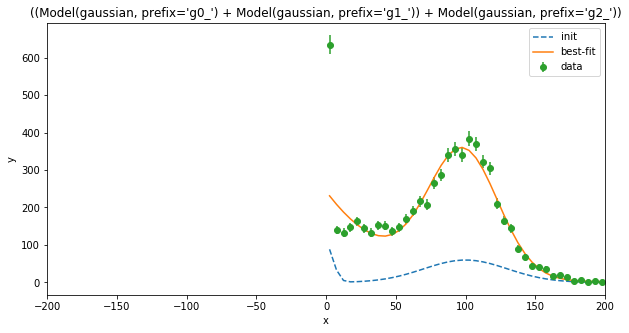

In [31]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.xlim(-200,200)
result.plot_fit()
print result.fit_report()
plt.show()